In [1]:
# import subprocess
DIR = 'input/'
PATH_TRAIN = DIR + 'simplified-nq-train.jsonl'
PATH_TEST = DIR + 'simplified-nq-test.jsonl'
# N_TRAIN_bytes = subprocess.check_output("wc -l {}".format(PATH_TRAIN), shell=True)
# N_TEST_bytes = subprocess.check_output("wc -l {}".format(PATH_TEST), shell=True)

# N_TRAIN = int(N_TRAIN_bytes.split()[0])
# N_TEST = int(N_TEST_bytes.split()[0])
# print(N_TRAIN)  307373
# print(N_TEST)  345

In [2]:
import numpy as np
import pandas as pd
import gc
import os
import string, re
import pickle
import json
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['KaiTi', 'Arial']})
import warnings
warnings.filterwarnings("ignore")  # 不显示警告

%matplotlib inline

N_TRAIN=307373
N_TEST=345

In [5]:
n_long_candidates_train = np.zeros(N_TRAIN)
t_long_train = np.zeros((N_TRAIN,2))
t_yesno_train = []
with open(PATH_TRAIN, 'rt') as f:
    for i in tqdm(range(N_TRAIN)):
        dic = json.loads(f.readline())
        n_long_candidates_train[i] = len(dic['long_answer_candidates'])
        t_long_train[i,0] = dic['annotations'][0]['long_answer']['start_token']
        t_long_train[i,1] = dic['annotations'][0]['long_answer']['end_token']
        t_yesno_train.append(dic['annotations'][0]['yes_no_answer'])

In [6]:
n_long_candidates_test = np.zeros(N_TEST)
with open(PATH_TEST, 'rt') as f:
    for i in tqdm(range(N_TEST)):
        dic = json.loads(f.readline())
        n_long_candidates_test[i] = len(dic['long_answer_candidates'])

In [7]:
print('the length of n_long_candidates_train:', end=' ')  # train中候选长答案的数目
print(len(n_long_candidates_train))
print('the shape of t_long_train:', end=' ')  # 长答案的开始index和终止index
print(t_long_train.shape)
print('the length of t_yesno_train:', end=' ')  # train中答案为yes或no的可能
print(len(t_yesno_train))

the length of n_long_candidates_train: 307373
the shape of t_long_train: (307373, 2)
the length of t_yesno_train: 307373


In [8]:
print('--------------------------------n_long_candidates_train[:5]---------------------------------------')
print(n_long_candidates_train[:5])
print('--------------------------------------t_long_train[:5]--------------------------------------------')
print(t_long_train[:5])
print('-------------------------------------t_yesno_train[:5]--------------------------------------------')
print(t_yesno_train[:5])

--------------------------------n_long_candidates_train[:5]---------------------------------------
[ 63.  37.  49. 481.  97.]
--------------------------------------t_long_train[:5]--------------------------------------------
[[ 1.952e+03  2.019e+03]
 [ 2.120e+02  3.100e+02]
 [ 3.190e+02  4.380e+02]
 [ 5.090e+02  5.760e+02]
 [-1.000e+00 -1.000e+00]]
-------------------------------------t_yesno_train[:5]--------------------------------------------
['NONE', 'NONE', 'NONE', 'NONE', 'NONE']


##### train中答案为NONE的占比最大，为98.76%
##### train中答案为YES的占比最大，为0.77%
##### train中答案为NO的占比最大，为0.47%

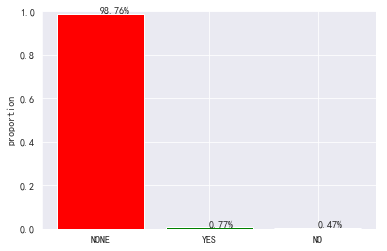

In [10]:
pro1 = np.sum(i == 'NONE' for i in t_yesno_train)/len(t_yesno_train)
pro2 = np.sum(i == 'YES' for i in t_yesno_train)/len(t_yesno_train)
pro3 = np.sum(i == 'NO' for i in t_yesno_train)/len(t_yesno_train)

plt.bar(range(3), [pro1, pro2, pro3], color='rgb', tick_label=['NONE','YES','NO'])
plt.ylabel('proportion')
plt.ylim([0, 1])
for x1, x2 in enumerate([pro1, pro2, pro3]):
    plt.text(x1, x2, '%.2f%%' % (x2 * 100))
plt.show()

##### train中备选长答案的分布——备选长答案最多有 7946 个！ 每个问题最少有1个备选长答案
##### test中备选长答案的分布——备选长答案最多有 1873 个！ 每个问题最少有2个备选长答案

In [11]:
print('--------------------------------n_long_candidates_train---------------------------------------')
print(pd.Series(n_long_candidates_train).describe())
print('---------------------------------n_long_candidates_test---------------------------------------')
print(pd.Series(n_long_candidates_test).describe())

--------------------------------n_long_candidates_train---------------------------------------
count    307373.000000
mean        131.354185
std         170.104565
min           1.000000
25%          45.000000
50%          87.000000
75%         158.000000
max        7946.000000
dtype: float64
---------------------------------n_long_candidates_test---------------------------------------
count     345.000000
mean      130.710145
std       171.995834
min         2.000000
25%        48.000000
50%        86.000000
75%       155.000000
max      1837.000000
dtype: float64


##### train中50.5%的开始、结束的index都为-1

In [12]:
print('--------------------------------t_long_train[:, 0]---------------------------------------')
print(pd.Series(t_long_train[:, 0]).describe())
print('--------------------------------t_long_train[:, 1]---------------------------------------')
print(pd.Series(t_long_train[:, 1]).describe())

--------------------------------t_long_train[:, 0]---------------------------------------
count    307373.000000
mean        532.571589
std        1600.149053
min          -1.000000
25%          -1.000000
50%          -1.000000
75%         367.000000
max       87343.000000
dtype: float64
--------------------------------t_long_train[:, 1]---------------------------------------
count    307373.000000
mean        722.793020
std        2041.141321
min          -1.000000
25%          -1.000000
50%          -1.000000
75%         535.000000
max      123780.000000
dtype: float64


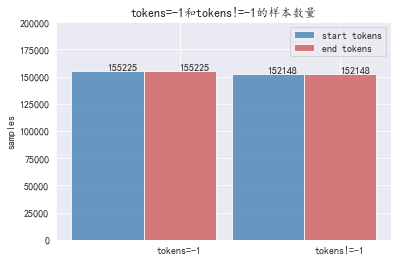

In [13]:
cnt1, cnt2 = 0, 0
for i in t_long_train:
    if int(i[0]) == -1:
        cnt1 += 1
    if int(i[1]) == -1:
        cnt2 += 1
y1 = [cnt1, len(t_long_train)-cnt1]
y2 = [cnt2, len(t_long_train)-cnt2]

bar_width = 0.45
plt.bar(np.arange(2), y1, label = 'start tokens', color = 'steelblue', alpha = 0.8, width = bar_width)
plt.bar(np.arange(2)+bar_width, y2, label = 'end tokens', color = 'indianred', alpha = 0.8, width = bar_width)
plt.xticks(np.arange(2)+bar_width, labels=['tokens=-1', 'tokens!=-1'])
plt.ylabel('samples')
plt.ylim([0, 200000])
plt.title('tokens=-1和tokens!=-1的样本数量')
for x1, x2 in enumerate(y1):
    plt.text(x1, x2+100, '%s' %x2)
for x1, x2 in enumerate(y2):
    plt.text(x1+bar_width, x2+100, '%s' %x2)
plt.legend()
plt.show()

##### 当开始和结束的token为-1时，yes or no的结果一定是NONE，反之不成立(因为yes or no的结果有98.76%为NONE)

In [14]:
print('{0:.2f}% of tokens are -1.'.format(np.sum(t_long_train[:,0] < 0) / N_TRAIN * 100))
cnt = 0
for i in range(len(t_long_train)):
    if int(t_long_train[i, 0]) == -1 and t_yesno_train[i] == 'NONE':
        cnt += 1
print('%.2f%% of yes or no are NONE.'% (cnt/len(t_yesno_train)*100))

50.50% of tokens are -1.
50.50% of yes or no are NONE.


In [29]:
del t_yesno_train, t_long_train, n_long_candidates_test, n_long_candidates_train
gc.collect()

5428

In [22]:
def build_train(train_path, n_rows=N_TRAIN, sampling_rate=15):
    with open(train_path) as f:
        processed_rows = []

        for i in tqdm(range(n_rows)):
            line = f.readline()
            if not line:
                break

            line = json.loads(line)

            text = line['document_text'].split(' ')
            question = line['question_text']
            annotations = line['annotations'][0]

            for i, candidate in enumerate(line['long_answer_candidates']):
                label = i == annotations['long_answer']['candidate_index']

                start = candidate['start_token']
                end = candidate['end_token']

                if label or (i % sampling_rate == 0):
                    processed_rows.append({
                        'text': " ".join(text[start:end]),
                        'is_long_answer': label,
                        'question': question,
                        'annotation_id': annotations['annotation_id']
                    })

        train = pd.DataFrame(processed_rows)

        return train


def build_test(test_path):
    with open(test_path) as f:
        processed_rows = []

        for line in tqdm(f):
            line = json.loads(line)

            text = line['document_text'].split(' ')
            question = line['question_text']
            example_id = line['example_id']

            for candidate in line['long_answer_candidates']:
                start = candidate['start_token']
                end = candidate['end_token']

                processed_rows.append({
                    'text': " ".join(text[start:end]),
                    'question': question,
                    'example_id': example_id,
                    'sequence': f'{start}:{end}'

                })

        test = pd.DataFrame(processed_rows)

    return test


directory = 'input/'
train_path = directory + 'simplified-nq-train.jsonl'
test_path = directory + 'simplified-nq-test.jsonl'

In [23]:
# dfff = pd.DataFrame(t_long_train)
# tqdm(dfff.to_csv("just_test.csv", index=None))

In [26]:
train_long = build_train(train_path)
train_long.to_csv("train_long.csv", index=None)

0/|/| 0/? [00:04<?, ?it/s]

In [27]:
test_long = build_test(test_path)
test_long.to_csv("test_long.csv", index=None)

0/|/| 0/? [00:00<?, ?it/s]

In [3]:
train = pd.read_csv('train_long.csv')
test = pd.read_csv('test_long.csv')

In [4]:
print('how many lines in train set:', train.shape)
print('how many lines in test set:', test.shape)

how many lines in train set: (2961338, 4)
how many lines in test set: (45163, 4)


In [5]:
print('-------------------------------------head--------------------------------------------')
print(train.head())
print('----------------------------------information----------------------------------------')
print(train.info())
print('-------------------------------- missing value---------------------------------------')
print(train.isnull().sum())
print('----------------------------------nan value------------------------------------------')
print(train.isna().sum())

-------------------------------------head--------------------------------------------
        annotation_id  is_long_answer  \
0  593165450220027640           False   
1  593165450220027640           False   
2  593165450220027640           False   
3  593165450220027640           False   
4  593165450220027640            True   

                                            question  \
0  which is the most common use of opt-in e-mail ...   
1  which is the most common use of opt-in e-mail ...   
2  which is the most common use of opt-in e-mail ...   
3  which is the most common use of opt-in e-mail ...   
4  which is the most common use of opt-in e-mail ...   

                                                text  
0  <Table> <Tr> <Td> </Td> <Td> ( hide ) This art...  
1  <Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...  
2  <P> Email marketing has evolved rapidly alongs...  
3  <Li> Advertisers can reach substantial numbers...  
4  <P> A common example of permission marketing i...  


In [6]:
print('-------------------------------------head--------------------------------------------')
print(test.head())
print('----------------------------------information----------------------------------------')
print(test.info())
print('-------------------------------- missing value---------------------------------------')
print(test.isnull().sum())
print('----------------------------------nan value------------------------------------------')
print(test.isna().sum())

-------------------------------------head--------------------------------------------
            example_id                                           question  \
0 -1220107454853145579  who is the south african high commissioner in ...   
1 -1220107454853145579  who is the south african high commissioner in ...   
2 -1220107454853145579  who is the south african high commissioner in ...   
3 -1220107454853145579  who is the south african high commissioner in ...   
4 -1220107454853145579  who is the south african high commissioner in ...   

  sequence                                               text  
0   18:136  <Table> <Tr> <Th_colspan="2"> High Commission ...  
1    19:30  <Tr> <Th_colspan="2"> High Commission of South...  
2    34:45  <Tr> <Th> Location </Th> <Td> Trafalgar Square...  
3    45:59  <Tr> <Th> Address </Th> <Td> Trafalgar Square ...  
4   59:126  <Tr> <Th> Coordinates </Th> <Td> 51 ° 30 ′ 30 ...  
----------------------------------information----------------------

##### train中仅有152148条数据是正确答案，正确答案与备选答案的比例为1：19

In [7]:
print('the number of correct answer in train set:', np.sum(train['is_long_answer']==True))

the number of correct answer in train set: 152148


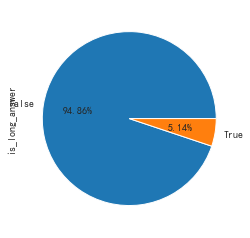

In [8]:
train['is_long_answer'].value_counts().plot.pie(autopct='%1.2f%%')

##### 取500条数据进行分析

In [9]:
answer_incom = train['text'][:500].copy()

In [10]:
# answer_incom[409]

In [11]:
for line in tqdm(range(len(answer_incom))):
    answer_incom[line] = re.sub(r'<.*?>', '', answer_incom[line])  # 去掉<>标签
    for i in string.punctuation:  # 去除标点符号
        answer_incom[line] = answer_incom[line].replace(i, '')
    answer_incom[line] = answer_incom[line].lower()  # 换为小写字母
    answer_incom[line]=nltk.word_tokenize(answer_incom[line])  # 进行分词处理

##### 记录每条备选答案的长度

In [12]:
def wordcount(line):
    return len(line)

word_count = list(answer_incom.map(wordcount))

In [13]:
answer_incom[:5]

0    [hide, this, article, has, multiple, issues, p...
1    [pay, per, click, cost, per, impression, searc...
2    [email, marketing, has, evolved, rapidly, alon...
3    [advertisers, can, reach, substantial, numbers...
4    [a, common, example, of, permission, marketing...
Name: text, dtype: object

##### 备选答案长度整体分析

In [14]:
pd.Series(word_count).describe()

count     500.000000
mean       61.714000
std       222.196451
min         0.000000
25%         7.000000
50%        16.500000
75%        64.250000
max      4056.000000
dtype: float64

##### 备选答案长度的分布, 似乎大部分集中在0-400

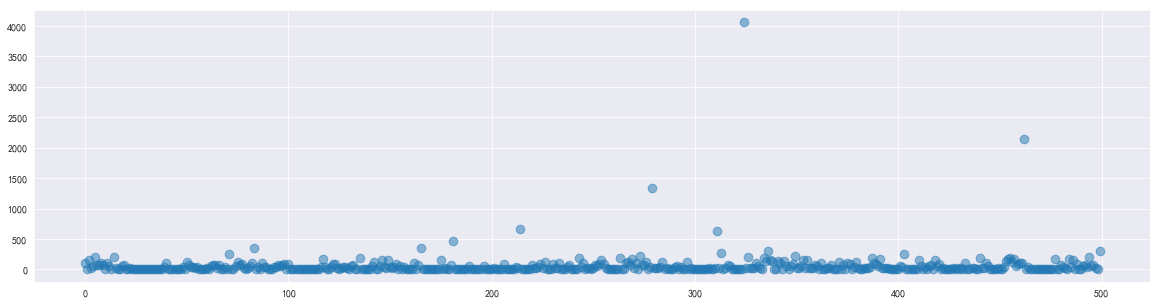

In [15]:
plt.figure(figsize=(20,5))
plt.scatter(range(len(word_count)), word_count, s=75, alpha=0.5)

##### 事实上，大多数长答案都没有很长

(0, 400)

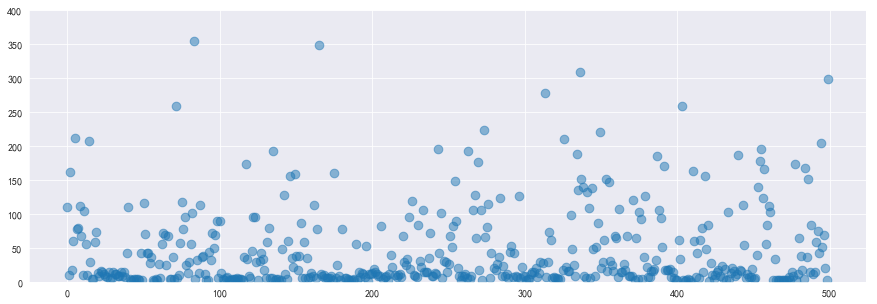

In [16]:
# x轴没有特殊含义，y轴代表答案长度
plt.figure(figsize=(15,5))
plt.scatter(range(len(word_count)), word_count, s=75, alpha=0.5)
plt.ylim(0, 400)

##### 总共出现了 7332 个不同的单词

In [17]:
word_list = []
for i in answer_incom:
    for j in range(len(i)):
        word_list.append(i[j])
print(len(set(word_list)))

7332


##### 重复单词有 23525 个！！！

In [18]:
len(word_list) - len(set(word_list))

23525

##### 显示前 20 个出现次数最多的单词

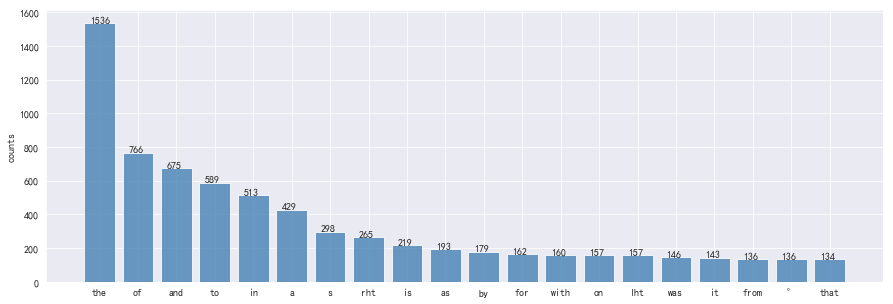

In [19]:
plt.figure(figsize=(15, 5))
data = pd.Series(word_list).value_counts()[:20]
plt.bar(range(20), data, align = 'center',color='steelblue', alpha = 0.8)
plt.ylabel('counts')
plt.xticks(range(20),data.index)
for x1, x2 in enumerate(data):
    plt.text(x1-0.25, x2, x2)
plt.show()

In [291]:
# def clean(line):    # 清洗
#     line = re.sub(r'<.*?>', '', line)
#     for i in string.punctuation:
#         line = line.replace(i, '')
#     return line.lower()
# answer = answer.map(clean)

# def wordtoken(line):    # 分词
#     wordsinstr=nltk.word_tokenize(line)
#     return wordsinstr
# answer = answer.map(wordtoken)

# def wordcount(line):    # 计数
#     return len(line)
# word_count = list(answer.map(wordcount))